In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

# %matplotlib notebook
%matplotlib inline

In [2]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    # compute power
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    # edge distances
    distance = np.random.uniform(low=1, high=3, size=len(G.edges))
    for ((a, b), d) in zip(G.edges, distance):
        G.edges[a, b]["distance"] = d
        G.edges[a, b]["delay"] = f"uniform {d * 0.5} {d * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / d
    distances = dict(nx.shortest_path_length(G, weight="distance"))
    # closeness / farness metrics
    node_attr = dict()
    for i, d in distances.items():
        farness = sum(d.values()) / (n - 1)
        compute_farness = sum([G.nodes[j]["compute"] * d for j, d in d.items()])
        node_attr[i] = dict(
            farness=farness,
            closeness=1 / farness,
            compute_farness=compute_farness,
            compute_closeness=1 / compute_farness,
        )
    nx.set_node_attributes(G, node_attr)
    # done
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000, seed=None):
    """
    Run simulator on given network G.
    """
    G = G.copy()
    type_of_node_key = type(list(G.nodes.keys())[0])
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    if seed:
        G.graph["seed"] = seed
    with subprocess.Popen(
        ["dune", "exec", "simulator/bin/igraph_runner.exe"],
        cwd="../..",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)


def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [3]:
G = barabasi_albert(n=7)
pd.DataFrame.from_dict(G.nodes, orient="index")

,compute,farness,closeness,compute_farness,compute_closeness
0,0.116993,2.089962,0.478478,1.922208,0.520235
1,0.134454,3.070035,0.325729,2.518302,0.397093
2,0.128754,3.772474,0.265078,3.258465,0.306893
3,0.213385,2.934035,0.340828,2.304844,0.433869
4,0.006671,2.846501,0.351309,2.817747,0.354893
5,0.207341,2.964673,0.337305,2.537516,0.394086
6,0.192402,2.952477,0.338699,2.465958,0.405522


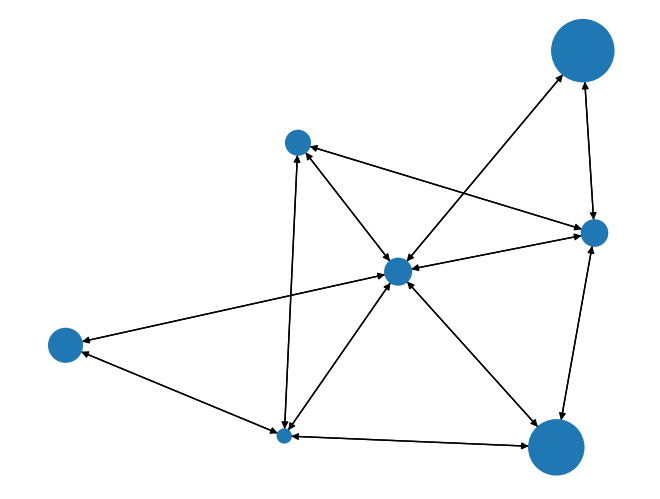

In [4]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=10000)
layout = draw(G)

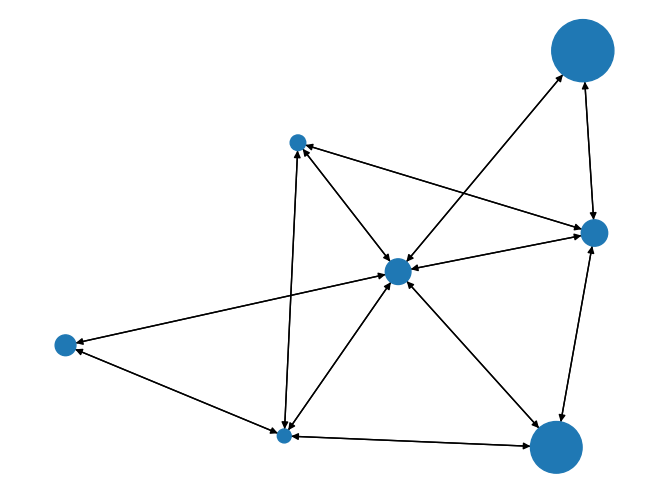

In [5]:
draw(G, size="reward", layout=layout)

In [6]:
runs = []
for i in range(10):
    net = barabasi_albert(n=7)
    cf = dict(G.nodes(data="compute_farness")).values()
    est_progagation_delay = sum(cf) / len(cf)
    for p in [
        "nakamoto",
        "ethereum-discount",
        "tailstorm-8-constant-heuristic",
        "tailstorm-8-discount-optimal",
    ]:
        G = sim(
            net,
            activation_delay=2 * est_progagation_delay,
            activations=1000,
            protocol=p,
            seed=i,
        )
        d = pd.DataFrame.from_dict(G.nodes, orient="index")
        d["protocol"] = p
        runs.append(d)
df = pd.concat(runs)
# calculate metrics
df["relative_reward"] = df.reward / np.sum(df.reward)
df["relative_activations"] = df.reward / np.sum(df.activations)
df["efficiency"] = df.reward / G.graph["head_progress"] / df.compute
df.efficiency.fillna(0, inplace=True)
display(df)

,activations,reward,compute_closeness,compute_farness,closeness,farness,compute,protocol,relative_reward,relative_activations,efficiency
0,181.0,132.000,0.572256,1.747471,0.467038,2.141155,0.178375,nakamoto,0.003969,0.003300,0.825908
1,295.0,265.000,0.634372,1.576362,0.380737,2.626485,0.299005,nakamoto,0.007967,0.006625,0.989143
2,123.0,58.000,0.335371,2.981773,0.281051,3.558068,0.137033,nakamoto,0.001744,0.001450,0.472383
3,4.0,3.000,0.459302,2.177219,0.409022,2.444855,0.002902,nakamoto,0.000090,0.000075,1.153907
4,50.0,19.000,0.274124,3.647985,0.266092,3.758103,0.043768,nakamoto,0.000571,0.000475,0.484500
...,...,...,...,...,...,...,...,...,...,...,...
2,259.0,181.750,0.398989,2.506334,0.325007,3.076861,0.271081,tailstorm-8-discount-optimal,0.005464,0.004544,0.748284
3,244.0,159.125,0.385582,2.593483,0.328537,3.043797,0.244606,tailstorm-8-discount-optimal,0.004784,0.003978,0.726043
4,130.0,81.875,0.338762,2.951929,0.338192,2.956903,0.133778,tailstorm-8-discount-optimal,0.002462,0.002047,0.683058
5,66.0,42.875,0.448687,2.228726,0.468087,2.136354,0.053762,tailstorm-8-discount-optimal,0.001289,0.001072,0.890069


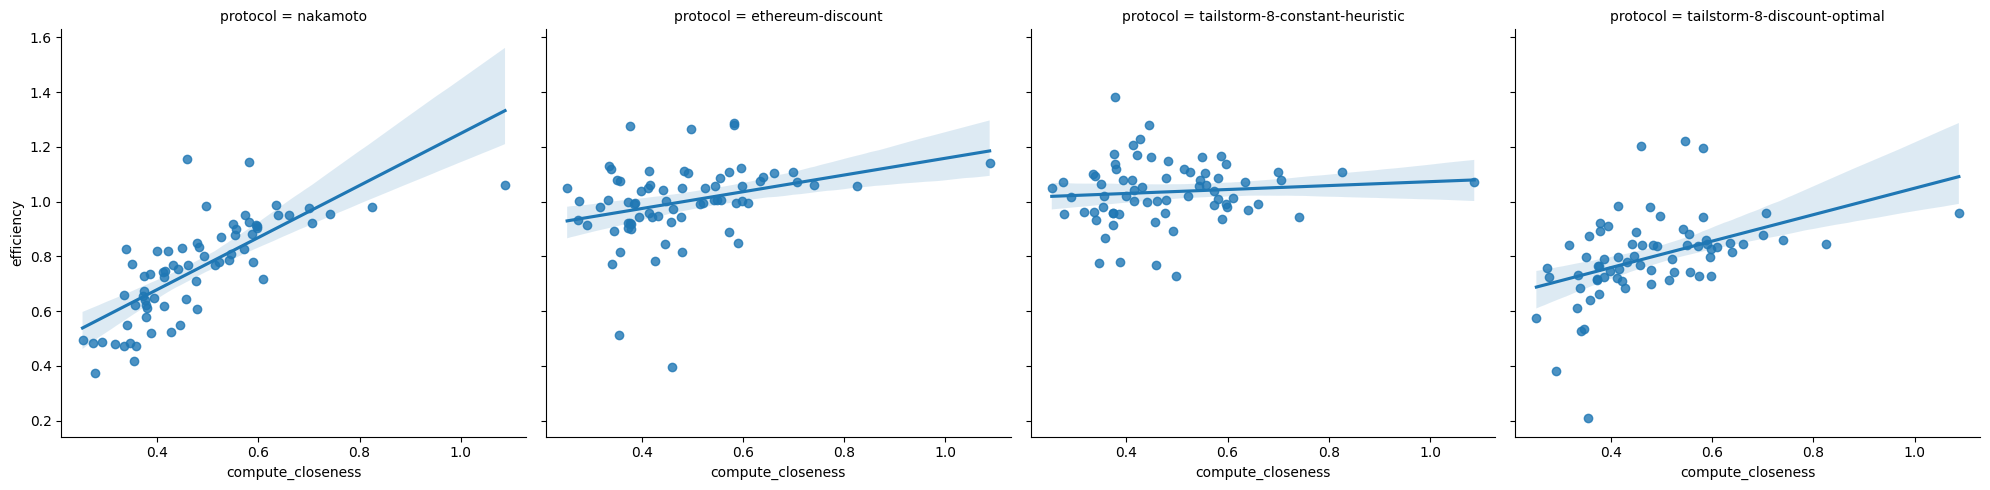

In [7]:
sns.lmplot(data=df, x="compute_closeness", y="efficiency", col="protocol")